In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# ------------------------
# HYPERPARAMETERS
# ------------------------
batch_size = 128
learning_rate = 1e-3
num_epochs = 100
latent_dim = 128

# ------------------------
# DEVICE
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# DATASET LOADING
# ------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ------------------------
# VAE MODEL DEFINITION
# ------------------------

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 128, 4, 4)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# ------------------------
# TRAINING
# ------------------------

vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

def train_vae(epochs):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

train_vae(num_epochs)



100%|██████████| 170M/170M [00:08<00:00, 20.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/100] Loss: 117.9532
Epoch [2/100] Loss: 84.8668
Epoch [3/100] Loss: 79.8426
Epoch [4/100] Loss: 78.2606
Epoch [5/100] Loss: 77.5074
Epoch [6/100] Loss: 76.9948
Epoch [7/100] Loss: 76.6016
Epoch [8/100] Loss: 76.2042
Epoch [9/100] Loss: 75.8852
Epoch [10/100] Loss: 75.6028
Epoch [11/100] Loss: 75.3588
Epoch [12/100] Loss: 75.2270
Epoch [13/100] Loss: 75.0913
Epoch [14/100] Loss: 75.0075
Epoch [15/100] Loss: 74.8327
Epoch [16/100] Loss: 74.7187
Epoch [17/100] Loss: 74.6185
Epoch [18/100] Loss: 74.6113
Epoch [19/100] Loss: 74.4940
Epoch [20/100] Loss: 74.4436
Epoch [21/100] Loss: 74.3268
Epoch [22/100] Loss: 74.2437
Epoch [23/100] Loss: 74.2825
Epoch [24/100] Loss: 74.2043
Epoch [25/100] Loss: 74.1330
Epoch [26/100] Loss: 74.1131
Epoch [27/100] Loss: 74.0485
Epoch [28/100] Loss: 73.9538
Epoch [29/100] Loss: 73.9593
Epoch [30/100] Loss: 73.9151
Epoch [31/100] Loss: 73.8758
Epoch [32/100] Loss:

In [5]:
model_path = "vae_cifar10.pth"
torch.save(vae.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to vae_cifar10.pth


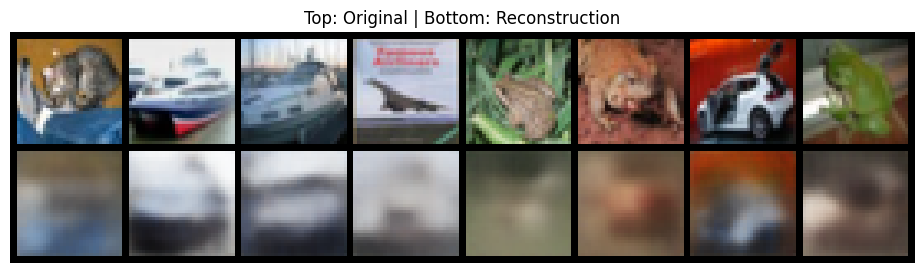

In [6]:
def show_reconstruction(n=8):
    vae.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon, _, _ = vae(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()
    comparison = torch.cat([imgs, recon])
    grid = make_grid(comparison, nrow=n)
    plt.figure(figsize=(15, 3))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Top: Original | Bottom: Reconstruction")
    plt.show()

show_reconstruction()

In [7]:
import numpy as np
from scipy import linalg
import torchvision.models as models

# Load pre-trained Inception v3 model with updated syntax
inception_model = models.inception_v3(
    weights=models.Inception_V3_Weights.IMAGENET1K_V1,  # Use modern weights parameter
    transform_input=False  # Keep original input normalization
)
# Remove auxiliary branches and final FC layer
inception_model.fc = nn.Identity()
inception_model.aux_logits = False  # Disable auxiliary outputs
inception_model = inception_model.to(device)
inception_model.eval()

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate Fréchet Inception Distance (FID) between two sets of features."""
    diff = mu1 - mu2
    # Add epsilon to avoid singular matrices
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

# Compute real image features
real_features = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        # Proper Inception preprocessing
        images = F.interpolate(images, size=299, mode='bilinear')
        images = (images - 0.5) * 2.0  # Scale from [0,1] to [-1,1] (Inception's expected range)
        features = inception_model(images)
        real_features.append(features.cpu())
real_features = torch.cat(real_features).numpy()

# Compute generated image features
n_samples = len(test_dataset)
generated_features = []
vae.eval()
with torch.no_grad():
    for _ in range(0, n_samples, batch_size):
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_images = vae.decode(z)
        # Match real image preprocessing
        gen_images = F.interpolate(gen_images, size=299, mode='bilinear')
        gen_images = (gen_images - 0.5) * 2.0
        features = inception_model(gen_images)
        generated_features.append(features.cpu())
generated_features = torch.cat(generated_features)[:n_samples].numpy()

# Calculate statistics
mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
mu_gen, sigma_gen = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

fid_score = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID Score: {fid_score:.2f}")

FID Score: 184.18
